In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
import mlxtend.frequent_patterns as fp
import mlxtend.preprocessing as mlp

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD

# Working with data: pre-processing

Initially, the idea was to take the whole country but it isn't so feascible. Alors, first we are taking:

1. top 5 cities --> CasosMexico.csv --> Procesamiento de datos
2. Comparing real dimension information with dimensionality reduction 
3. Different types of clustering: what to they mean here
4. Different score in clusters with final clasification: different patterns

In [3]:
columnas2 = ["ORIGEN","SECTOR","ENTIDAD_UM","SEXO","ENTIDAD_NAC","ENTIDAD_RES",
            "MUNICIPIO_RES","TIPO_PACIENTE","FECHA_INGRESO","INTUBADO","NEUMONIA","EDAD",
            "NACIONALIDAD","EMBARAZO","HABLA_LENGUA_INDIG","INDIGENA","DIABETES","EPOC","ASMA","INMUSUPR",
            "HIPERTENSION","OTRA_COM","CARDIOVASCULAR","OBESIDAD","RENAL_CRONICA","TABAQUISMO","OTRO_CASO",
             "TOMA_MUESTRA_LAB","RESULTADO_LAB","TOMA_MUESTRA_ANTIGENO", "RESULTADO_ANTIGENO","CLASIFICACION_FINAL",
            "UCI"]
datos_hoy = pd.read_csv("210124COVID19MEXICO.csv", usecols = columnas2)

In [4]:
datos_hoy['FECHA_INGRESO'] = pd.to_datetime(datos_hoy['FECHA_INGRESO'])

In [5]:
X = datos_hoy[(datos_hoy['FECHA_INGRESO'] > '2020-12-20 00:00:00')]

In [6]:
X.shape, datos_hoy.shape

((988564, 33), (4426668, 33))

In [7]:
X.drop(['FECHA_INGRESO'], axis=1,inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Reducción de dimensionalidad

Preferiblemente algo que podamos visualizar, pero podemos extenderlo un poco más en caso de mostrar cosas prometedoras. 

In [55]:
#CHOOSING DIMENSION
Incremental = []
Simple = []


In [56]:
print("PCA simple, con SVD truncado")
for i in range(1,32):
    pca = PCA(n_components=i, svd_solver='arpack', random_state=42)
    pca.fit(X)
    Simple.append(sum(pca.explained_variance_ratio_))

PCA simple, con SVD truncado


In [57]:
print("PCA Incremental")
for i in range(1,32):
    incre = IncrementalPCA(n_components=i, batch_size=200)
    incre.fit(X)
    Incremental.append(sum(incre.explained_variance_ratio_))

PCA Incremental


In [20]:
Incremental[1]

array([0.31366333])

<AxesSubplot:>

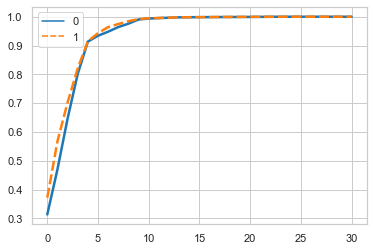

In [59]:
sns.set_theme(style="whitegrid")
sns.lineplot(data=[Incremental,Simple], palette="tab10", linewidth=2.5)

In [50]:
sum(sim[0:5])

0.9147895806928507

Nos quedamos con cinco dimensiones. Manetnemos el 91.47% de la información. Observación: pca incremental es mucho más suave. 

In [62]:
pca = PCA(n_components=5, svd_solver='arpack', random_state=42)
Data = pca.fit_transform(X)

In [8]:
Mor = X[X["ENTIDAD_UM"]==16]
CM = X[X["ENTIDAD_UM"]==9]

In [68]:
Simple2 = []
Incremental2 = []
print("PCA simple, con SVD truncado")
for i in range(1,32):
    pca = PCA(n_components=i, svd_solver='arpack', random_state=42)
    pca.fit(Mor)
    Simple2.append(sum(pca.explained_variance_ratio_))
    
print("PCA Incremental")
for i in range(1,32):
    incre = IncrementalPCA(n_components=i, batch_size=200)
    incre.fit(Mor)
    Incremental2.append(sum(incre.explained_variance_ratio_))

PCA simple, con SVD truncado
PCA Incremental


In [69]:
Simple3 = []
Incremental3 = []
print("PCA simple, con SVD truncado")
for i in range(1,32):
    pca = PCA(n_components=i, svd_solver='arpack', random_state=42)
    pca.fit(CM)
    Simple3.append(sum(pca.explained_variance_ratio_))
    
print("PCA Incremental")
for i in range(1,32):
    incre = IncrementalPCA(n_components=i, batch_size=200)
    incre.fit(CM)
    Incremental3.append(sum(incre.explained_variance_ratio_))

PCA simple, con SVD truncado
PCA Incremental


In [72]:
#Comparacion PCA 
comparacion = pd.DataFrame([Simple,Simple2,Simple3,Incremental,Incremental2,Incremental3], columns= [i for i in range(31)])

In [79]:
comparacion

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.371656,0.567257,0.702375,0.820759,0.914790,0.943014,0.964201,0.974657,0.984361,0.991885,...,0.999736,0.999868,0.999981,0.999996,0.999999,1.0,1.0,1.0,1.0,1.0
1,0.301998,0.546425,0.745860,0.841696,0.886454,0.925838,0.949485,0.971595,0.988525,0.991300,...,0.999925,0.999979,0.999994,0.999999,1.000000,1.0,1.0,1.0,1.0,1.0
2,0.310799,0.574308,0.772874,0.849234,0.901202,0.935653,0.967928,0.980358,0.987119,0.993421,...,0.999805,0.999981,0.999997,0.999999,1.000000,1.0,1.0,1.0,1.0,1.0
3,0.313663,0.469913,0.646338,0.801830,0.913752,0.934027,0.948145,0.964157,0.976031,0.990471,...,0.999621,0.999856,0.999978,0.999994,0.999999,1.0,1.0,1.0,1.0,1.0
4,0.298390,0.500623,0.608283,0.665197,0.778798,0.893462,0.946771,0.968039,0.988436,0.990722,...,0.999918,0.999973,0.999993,0.999999,1.000000,1.0,1.0,1.0,1.0,1.0
5,0.249664,0.551631,0.694483,0.846858,0.898846,0.931601,0.963738,0.976285,0.986921,0.993418,...,0.999786,0.999979,0.999997,0.999999,0.999999,1.0,1.0,1.0,1.0,1.0


<AxesSubplot:>

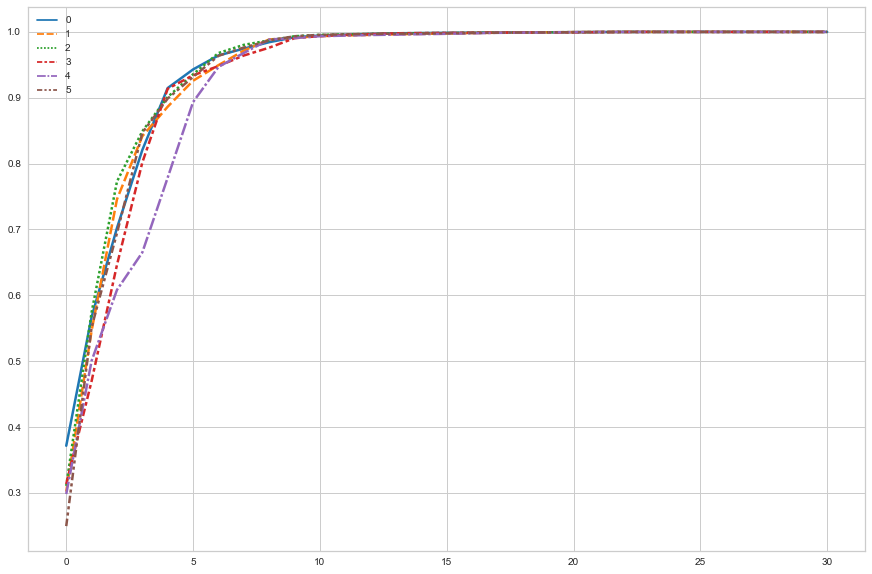

In [85]:
##### sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=[Simple,Simple2,Simple3,Incremental,Incremental2,Incremental3], palette="tab10", linewidth=2.5)

Observaciones: Incremental 2, la de Morelia, necesita más componentes. Son la simple, lo hace bien con 5 componentes.
Para CDMX: lo hizo mejor con 5 componentes lo hizo ligeramente mejor con el simple. 
Para todos los datos: con 5 componentes también el simple. 

# Clusterización

Me voy a quedar con los datos reducidor por cuestiones de procesamiento, aún así guardamos una gran cantidad de información

In [9]:
pca = PCA(n_components=5, svd_solver='arpack', random_state=42)
Data = pca.fit_transform(X)

In [10]:
pca2 = PCA(n_components=5, svd_solver='arpack', random_state=42)
data_CM = pca2.fit_transform(CM)

In [11]:
pca3 = PCA(n_components=5, svd_solver='arpack', random_state=42)
data_mor = pca3.fit_transform(X)

### KMeans: ¿Cómo elijo cuántos datos?

In [13]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

In [12]:
aglomerado = AgglomerativeClustering(Data)
kmedias = KMeans()

aglomerado2 = AgglomerativeClustering(data_mor)
kmedias2 = KMeans()

aglomerado3 = AgglomerativeClustering(data_CM)
kmedias3 = KMeans()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

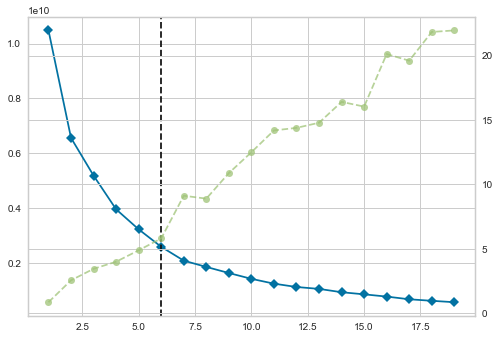

In [16]:
visualizer1 = KElbowVisualizer(kmedias, k=(1,20)) #Creo que tener más de 20 grupos ya es muy descabellado para los fines
visualizer1.fit(Data)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

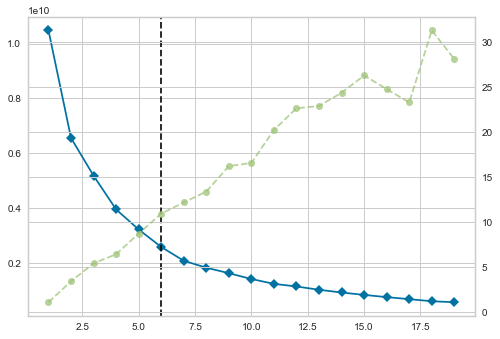

In [35]:
visualizer2 = KElbowVisualizer(kmedias2, k=(1,20)) #Creo que tener más de 20 grupos ya es muy descabellado para los fines
visualizer2.fit(data_mor)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

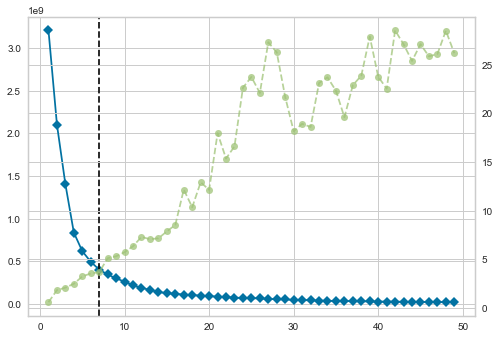

In [36]:
visualizer3 = KElbowVisualizer(kmedias3, k=(1,50)) #Creo que tener más de 50 grupos ya es muy descabellado para los fines
visualizer3.fit(data_CM)

In [12]:
kmeans_mor = KMeans(n_clusters=6, random_state=0).fit(data_mor)
y_pred1 = kmeans_mor.labels_

In [13]:
kmeans_cm = KMeans(n_clusters=7, random_state=0).fit(data_CM)
y_pred2 = kmeans_cm.labels_

In [14]:
kmeans_ = KMeans(n_clusters=6, random_state=0).fit(Data)
y_pred3 = kmeans_.labels_

## Reglas de asociación 

### Morelia

In [ ]:
onehotEncoder = TransactionEncoder()
datosOnehotCodeados = onehotEncoder.fit(data_mor).transform(data_mor)